In [1]:
import numpy as np
from typing import Sequence, Tuple, Literal
import matplotlib.pyplot as plt

In [2]:
fmn_neutral_hfcs = np.array([0.390, -0.769, -0.158, 0.2675, 0.393, 0.212])
fmn_neutral_atoms = ['H1', 'H5', 'H6', '8-CH3', 'N5', 'N10']
fmn_neutral_g = 2.0036

fmn_anion_hfcs = np.array([-0.35, 0.40, 0.73, 0.31])
fmn_anion_atoms = ['H6', '8-CH3', 'N5', 'N10']
fmn_anion_g = 2.0034

tyr_neutral_hfcs = np.array([0.15, -0.65, -0.65, 0.15, 0.77])
tyr_neutral_atoms = ['H2', 'H3', 'H5', 'H6', 'Hbeta']
tyr_neutral_g = 2.0041

trp_neutral_hfcs = np.array([-0.05, -0.40, 0.03, -0.32, -0.08, 0.29, 1.08, 0.25])
trp_neutral_atoms = ['H2', 'H4', 'H5', 'H6', 'H7', 'hbeta1', 'Hbeta2', 'N1']
trp_neutral_g = 2.0028

trp_cation_hfcs = np.array([-0.34, -0.47, -0.51, 0.06, -0.35, -0.21, 0.33, 0.84, 0.25])
trp_cation_atoms = ['NH(H1)', 'H2', 'H4', 'H5', 'H6', 'H7', 'hbeta1', 'Hbeta2', 'N1']
trp_cation_g = 2.0028

In [3]:
def _enumerate_spin_states_from_base(base: Sequence[int]) -> np.ndarray:
    """
    Return all spin-state patterns for a mixed-radix 'base' (e.g. [2,2,3,...]).
    Each row corresponds to one configuration. For base[i]=b, the digit d in [0..b-1]
    maps to spin projection m = (b-1)/2 - d.
    """
    base = np.asarray(base, dtype=int)
    size = len(base)
    total = int(np.prod(base))

    # Build digits for all states at once via mixed-radix division
    # states: 0..total-1
    n = np.arange(total, dtype=np.int64)[:, None]  # (total, 1)
    digits = np.empty((total, size), dtype=np.int64)

    # Least-significant position first
    for i in range(size):
        b = base[i]
        digits[:, i] = n[:, 0] % b
        n //= b

    # Map digits -> spin projections m_i = (b-1)/2 - digit
    m = (base.astype(np.float64) - 1.0) / 2.0
    patterns = m[None, :] - digits.astype(np.float64)
    return patterns  # shape: (total, size)

In [8]:
def cidnp_intensity(
    *,
    # Field grid
    b0_start: float,
    b0_end: float,
    n_points: int,
    # Electronic params
    deltag: float,                 # g-difference (dimensionless)
    # Model selection
    model: Literal["a", "b", "c"], # 'a' exponential, 'b' truncated t^{-3/2}, 'c' full diffusion
    ks: float | None = None,       # needed for model 'a'
    alpha: float | None = None,    # needed for model 'c'
    # Nuclei counts
    dnuc: int, anuc: int,          # spin-1/2 on donor/acceptor
    dnuc1: int, anuc1: int,        # spin-1 on donor/acceptor
    nucint: int,                   # 1-based index within the spin-1/2 list (donor first, then acceptor)
    # Hyperfine couplings (mT)
    dhfc: Sequence[float] = (),
    ahfc: Sequence[float] = (),
    dhfc1: Sequence[float] = (),
    ahfc1: Sequence[float] = (),
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute CIDNP polarisation vs field for a radical pair with given parameters.
    Inputs:
      - b0_start, b0_end in Tesla; n_points >= 1
      - deltag = g_donor - g_acceptor
      - model: 'a' (exponential), 'b' (truncated diffusion), 'c' (full diffusion)
      - ks (s^-1) for model 'a'; alpha (dimensionless, 2m/ρ) for model 'c'
      - dnuc, anuc: numbers of spin-1/2 nuclei on donor/acceptor
      - dnuc1, anuc1: numbers of spin-1 nuclei on donor/acceptor
      - nucint: 1-based index of the spin-1/2 nucleus of interest (within dnuc+anuc)
      - dhfc, ahfc, dhfc1, ahfc1: hyperfines in mT (magnitudes). Donor positive, acceptor negative.

    Returns:
      b0_grid (T), p_grid (polarisation at each field point)
    """

    # ---- constants ----
    pi   = np.pi
    muB  = 9.427401e-24     # J/T
    hbar = 1.05457e-34      # J·s
    to_omega = 2.8e10 * 2.0 * pi  # (T -> rad/s) for hyperfine conversion

    # ---- assemble hyperfine arrays (mT -> T; then -> angular frequency) ----
    assert len(dhfc) == dnuc and len(ahfc) == anuc, "spin-1/2 HFC lengths mismatch"
    assert len(dhfc1) == dnuc1 and len(ahfc1) == anuc1, "spin-1 HFC lengths mismatch"
    nnuc  = dnuc + anuc        # total spin-1/2
    nnuc1 = dnuc1 + anuc1      # total spin-1
    nnuct = nnuc + nnuc1

    # spin-1/2 list, donor then acceptor, acceptor negated
    hfc_half = np.empty(nnuc, dtype=np.float64)
    if dnuc:
        hfc_half[:dnuc] = np.asarray(dhfc, dtype=np.float64) / 1e3
    if anuc:
        hfc_half[dnuc:] = -np.asarray(ahfc, dtype=np.float64) / 1e3

    # spin-1 list
    hfc_one = np.empty(nnuc1, dtype=np.float64)
    if dnuc1:
        hfc_one[:dnuc1] = np.asarray(dhfc1, dtype=np.float64) / 1e3
    if anuc1:
        hfc_one[dnuc1:] = -np.asarray(ahfc1, dtype=np.float64) / 1e3

    # convert to angular frequency
    if nnuc:
        hfc_half *= to_omega
    if nnuc1:
        hfc_one *= to_omega

    # ---- build hfcmod = all HFCs except the spin-1/2 nucleus of interest, then append spin-1 ----
    assert 1 <= nucint <= max(nnuc, 1), "nucint out of range (1-based index into spin-1/2 list)"
    if nnuc <= 0:
        raise ValueError("At least one spin-1/2 nucleus is required.")

    idx0 = nucint - 1  # convert to 0-based
    hfcmod = np.empty(nnuct - 1, dtype=np.float64)
    # all spin-1/2 except the interest nucleus
    if idx0 > 0:
        hfcmod[:idx0] = hfc_half[:idx0]
    if idx0 < nnuc - 1:
        hfcmod[idx0:nnuc-1] = hfc_half[idx0+1:]
    # append spin-1
    if nnuc1:
        hfcmod[nnuc-1:] = hfc_one

    # ---- base vector for mixed-radix enumeration: 2 for remaining spin-1/2, 3 for spin-1 ----
    base = ([2] * (nnuc - 1)) + ([3] * nnuc1)  # length = nnuct - 1

    # ---- all spin state patterns (total_states x (nnuct-1)) ----
    if len(base) == 0:
        # Corner case: only one spin-1/2 nucleus (the one of interest), no others
        patterns = np.zeros((1, 0), dtype=np.float64)  # one "empty" pattern
    else:
        patterns = _enumerate_spin_states_from_base(base)

    # onuc for every state: dot(pattern, hfcmod)
    onuc_all = patterns @ hfcmod  # shape: (total_states,)

    # precompute scale factor 2^(N-1) * 3^M
    scale = (2.0 ** max(nnuc - 1, 0)) * (3.0 ** nnuc1)

    # the HFC of the nucleus of interest (angular frequency)
    hfc_star = hfc_half[idx0]

    # ---- field grid ----
    if n_points == 1:
        b0_grid = np.array([(b0_start + b0_end) / 2.0], dtype=np.float64)
    else:
        b0_grid = np.linspace(b0_start, b0_end, int(n_points), dtype=np.float64)

    # ---- model checks ----
    if model == "a" and ks is None:
        raise ValueError("Model 'a' requires ks.")
    if model == "c" and alpha is None:
        raise ValueError("Model 'c' requires alpha.")

    # ---- compute polarisation vs field (vectorized over states) ----
    p_grid = np.empty_like(b0_grid)
    for k, b0 in enumerate(b0_grid):
        base_omega = (deltag * muB * b0) / hbar   # Δg μB B0 / ħ
        omega_plus  = base_omega + 0.5 * hfc_star + onuc_all
        omega_minus = base_omega - 0.5 * hfc_star + onuc_all

        if model == "a":
            # Exponential model: sum[ ω^2 / (ks^2 + 4 ω^2) ] difference
            ks2 = float(ks) ** 2
            term = (omega_plus**2) / (ks2 + 4.0 * omega_plus**2) \
                 - (omega_minus**2) / (ks2 + 4.0 * omega_minus**2)
            p = np.sum(term, dtype=np.float64)

        elif model == "b":
            # Truncated t^{-3/2}: sum[ sqrt(|ω+|) - sqrt(|ω-|) ]
            p = np.sum(np.sqrt(np.abs(omega_plus)) - np.sqrt(np.abs(omega_minus)),
                       dtype=np.float64)

        else:  # model == "c"
            # Full diffusion: use ω in Tesla (avoid exp underflow)
            op_T = omega_plus  / to_omega
            om_T = omega_minus / to_omega
            r_op = np.sqrt(np.abs(op_T))
            r_om = np.sqrt(np.abs(om_T))
            a = float(alpha)
            f = lambda r: 1.0 - np.exp(-a * r) * np.cos(a * r)
            p = np.sum(f(r_op) - f(r_om), dtype=np.float64)

        p_grid[k] = p / scale

    return b0_grid, p_grid

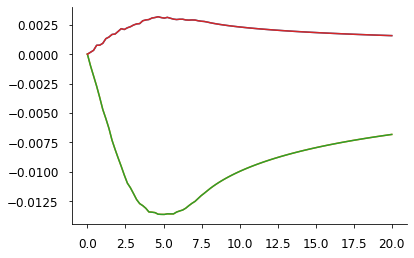

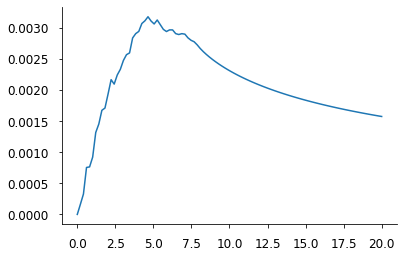

In [14]:
for i in range(1,5):
    b0, p = cidnp_intensity(
        b0_start=0.0, b0_end=20.0, n_points=100,
        deltag=tyr_neutral_g - fmn_neutral_g,
        model="c", ks=5e8,
        alpha=1.5,
        dnuc=5, anuc=4, dnuc1=0, anuc1=0,
        nucint=i,
        dhfc=[0.15, -0.65, -0.65, 0.15, 0.77],
        ahfc=[0.390, -0.769, -0.17, 0.24],
        dhfc1=[], ahfc1=[],
    )
    plt.plot(b0, p)


# p /= p.max()
plt.figure(2)
plt.plot(b0, p)
plt.show()
